# Predicting the Outcome of Clinical Trials

### Overview of Model

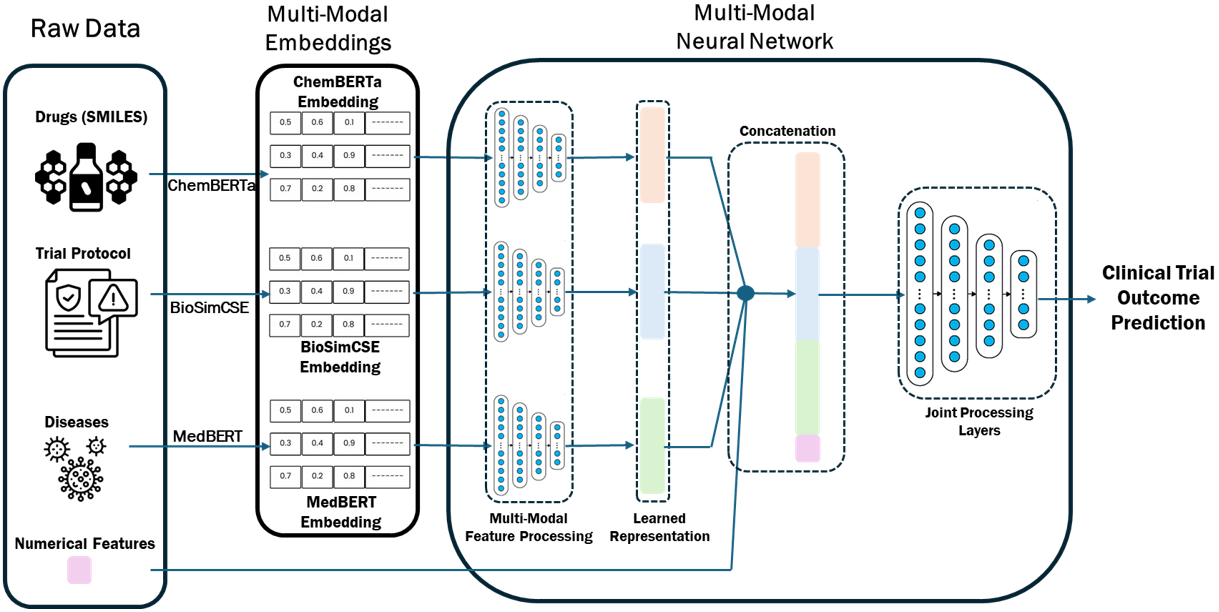


## Introduction

### Background

Getting new drugs to market is a long, expensive, and high-risk process. Typically, it takes 12 to 15 years [[1](https://doi.org/10.3389/fddsv.2023.1201419)], costs anywhere between 1 and 3 billion USD [[2](https://www.frontiersin.org/articles/10.3389/fmed.2021.760762/full)], and has a very low chance of success, with some sources estimating it as low as 7.9% from Phase I to market [[3](https://go.bio.org/rs/490-EHZ-999/images/ClinicalDevelopmentSuccessRates2011_2020.pdf)]. The drug discovery and development process can be broken down into multiple stages, from target validation to drug market launch (Fig. 1). Despite the hundreds of millions invested in bringing drugs to clinical trials, their success rate remains very low. This high failure rate is a significant driver of the overall costs of drug development. Identifying which molecules are likely to succeed can have a substantial positive impact by decreasing the failure rate—and therefore the costs—and increasing the speed at which new treatments reach patients.

By building models that can estimate the chances of success of a clinical trial, we can provide pharmaceutical companies with a crucial additional layer of information for decision-making. This insight can help companies assess whether the potential benefits of proceeding with a trial outweigh the associated risks and costs. As a result, these models can guide more informed decisions about which drug candidates to advance to clinical trials and which to discard, ultimately optimizing the allocation of resources, reducing the risk of costly failures, and accelerating the delivery of promising new treatments to patients.

### Packages required for this notebook

Note: this notebook was run on  Google Colab with a mounted drive. Make sure to make the necessary changes to run it locally.

In [ ]:
# Connecting to drive
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Clinical Trials Outcomes')

# Change this variable to compute embeddings
run_embeddings = False

Mounted at /content/drive


In [ ]:
!pip install sentence_transformers optuna
import pandas as pd
from helpers import build_ChemBERTa_features, build_medBERT_features, build_tinybioBERT_features, build_BioSimCSE_features, longest_and_average_word_count # from helpers.py file
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, precision_recall_curve, auc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import xgboost as xgb
import optuna
from sklearn.dummy import DummyClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

# Set global random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 12.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1

## Data Processing

#### Importing data

Data for clinical trials is publicly available at clinicaltrials.gov. In this work, we will use a benchmark dataset curated by T. Fu et. al. [[4](10.1016/j.patter.2022.100445)], who extracted data from clinicaltrials.gov and teamed up with IQVIA to label the outcomes of 17,538 clinical trials.

The data can be accessed on their github: https://github.com/futianfan/clinical-trial-outcome-prediction/blob/main/data/raw_data.csv

This dataset contains information such as the diseases being treated, the drugs being used (as well as their [SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) representation), the unique trial identifier (NCTID), the phase of the clinical trial, the inclusion/exclusion criteria, and whether the trial was successful or not (label).

For this work, this dataset was augmented by retrieving the brief summary of the clinical trial process using data from https://clinicaltrials.gov/AllPublicXML.zip and matching the summaries to the trial using the NCTID after parsing the XML file.

It is important to note that the dataset is relatively small, with only 17,538 clinical trials. To capture the complex relationships between drugs, diseases, trial protocols, and outcomes effectively, a significantly larger dataset would be ideal. This limited sample size may impact the model's ability to generalize and accurately predict outcomes across a wide range of scenarios, potentially affecting the reliability of predictions for less common drug-disease combinations or novel trial designs.

In [ ]:
# Import data from T. Fu et. al. as pandas dataframe
raw_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Clinical Trials Outcomes/data/raw_data.csv')
# Dropping 'why_stop' and 'status', as it is not available before doing the clinical trial, and icdcodes and drugs (keeping diseases and smiles)
raw_data.drop(columns=['why_stop', 'status', 'icdcodes', 'drugs'], inplace=True)


# We want to augment the raw data with a brief description of the clinical trial procedure. These sentences are taken from clinicaltrials.gov database
# Important to note: the brief_summary of the clinical trials does not take into account the results and would therefore be available before starting
# a would-be clinical trial. The summary does not describe the results, rather the trial protocol.

all_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Clinical Trials Outcomes/data/compiled_clinical_trials_data.csv') # all clinical trials from clinicaltrials.gov

# Getting the brief summary of the clinical trials
augmented_data = pd.merge(raw_data, all_data[['nctid', 'brief_summary']], on='nctid', how='left')

# Display the first few rows of the augmented DataFrame
augmented_data.head(3)

,nctid,label,phase,diseases,smiless,criteria,brief_summary
0,NCT00000172,1,phase 3,['alzheimer disease'],['[H][C@]12C[C@@H](O)C=C[C@]11CCN(C)CC3=C1C(O2...,\n Inclusion Criteria:\r\n\r\n ...,\n Galantamine is an experimental drug be...
1,NCT00000173,1,phase 3,['alzheimer disease'],['O=S(=O)(C1=CC=CC=C1)C1=CN=C2C(C=CC=C2N2CCNCC...,\n Inclusion Criteria:\r\n\r\n ...,\n The National Institute on Aging (NIA) ...
2,NCT00000174,0,phase 3,"['alzheimer disease', 'cognition disorders']",['CCN(C)C(=O)OC1=CC=CC(=C1)[C@H](C)N(C)C'],\n Inclusion Criteria:\r\n\r\n ...,\n This phase IIIb trial is a prospective...


##### Cleaning the data

We then perform a bit of data cleaning to make the data more usable.

The criteria column is split into inclusion and exclusion criteria.

For the cases where multiple drugs are used in a trial, their SMILES representation is separated by a '.', a common delimiter for SMILES.

The clinical phases are one-hot encoded.

In [ ]:
# Removing rows with missing data
augmented_data.dropna(subset=['brief_summary'], inplace=True) # 1 row removed
augmented_data.dropna(subset=['criteria'], inplace=True) # 2 rows removed

# Create 'number of drugs' category
augmented_data['n_drugs'] = augmented_data['smiless'].str.count(',') + 1

# Remove the \n
augmented_data['brief_summary'] = augmented_data['brief_summary'].str.slice(3)
# Remove the \r and \n
augmented_data['criteria'] = augmented_data['criteria'].str.replace('\r', '', regex=False).str.replace('\n', ' ', regex=False).str.replace(':', ' ', regex=False)
# Remove 'Inclusion' & 'criteria' from the 'criteria' column
augmented_data['criteria'] = augmented_data['criteria'].str.replace('Inclusion', '', regex=False).str.replace('inclusion', '', regex=False).str.replace('Criteria', '', regex=False).str.replace('criteria', '', regex=False)
augmented_data['criteria'] = augmented_data['criteria'].str.replace('INCLUSION', '', regex=False).str.replace('CRITERIA', '', regex=False)
# Remove the []'
augmented_data['diseases'] = augmented_data['diseases'].str.replace('[', '', regex=False).str.replace("'", '', regex=False).str.replace(']', '', regex=False)
# Remove the first and last two chars of SMILES.
augmented_data['smiless'] = augmented_data['smiless'].str.slice(2, -2)
# Use the dot '.' as delimiter of molecules when we have multiple drugs
augmented_data['smiless'] = augmented_data['smiless'].str.replace("', '", ".")

# Remove double or more spaces
augmented_data['criteria'] = augmented_data['criteria'].str.replace(r'\s{2,}', ' ', regex=True)

# Function to split the criteria into inclusion and exclusion
def split_criteria(text):
    if 'Exclusion' in text:
        inclusion, exclusion = text.split('Exclusion', 1)
        return pd.Series([inclusion.strip(), exclusion.strip()])
    elif 'EXCLUSION' in text:
        inclusion, exclusion = text.split('EXCLUSION', 1)
        return pd.Series([inclusion.strip(), exclusion.strip()])
    else:
        # Handle cases where neither "Exclusion" nor "EXCLUSION" is found
        return pd.Series([text.strip(), 'No exclusion criteria found.'])

# Apply the function to the 'criteria' column
augmented_data[['Inclusion Criteria', 'Exclusion Criteria']] = augmented_data['criteria'].apply(split_criteria)

# Drop the original 'criteria' column if no longer needed
augmented_data = augmented_data.drop(columns=['criteria'])

# We will one-hot encode the clinical phase of the trials
augmented_data = pd.get_dummies(augmented_data, columns=['phase'])
augmented_data.head(3)

,nctid,label,diseases,smiless,brief_summary,n_drugs,Inclusion Criteria,Exclusion Criteria,phase_early phase 1,phase_phase 1,phase_phase 1/phase 2,phase_phase 2,phase_phase 2/phase 3,phase_phase 3,phase_phase 4
0,NCT00000172,1,alzheimer disease,[H][C@]12C[C@@H](O)C=C[C@]11CCN(C)CC3=C1C(O2)=...,Galantamine is an experimental drug being ...,1,- Probable Alzheimer's disease - Mini-Mental S...,- Conditions that could confound diagnosis - N...,False,False,False,False,False,True,False
1,NCT00000173,1,alzheimer disease,O=S(=O)(C1=CC=CC=C1)C1=CN=C2C(C=CC=C2N2CCNCC2)...,The National Institute on Aging (NIA) is l...,2,- Memory complaints and memory difficulties wh...,- Any significant neurologic disease other tha...,False,False,False,False,False,True,False
2,NCT00000174,0,"alzheimer disease, cognition disorders",CCN(C)C(=O)OC1=CC=CC(=C1)[C@H](C)N(C)C,"This phase IIIb trial is a prospective, ra...",1,"- Are aged 55-85 years, inclusive. Subjects ol...","- Advanced, severe, and unstable disease of an...",False,False,False,False,False,True,False


In [ ]:
# Useful to know average number of tokens we will be dealing with.
# Get the longest word count and average word count for the specified columns
results = longest_and_average_word_count(augmented_data, ['brief_summary', 'Inclusion Criteria', 'Exclusion Criteria'])

# Print the results
for column, (longest_count, average_count) in results.items():
    print(f"{column} - Longest word count: {longest_count}, Average word count: {average_count:.2f}")

brief_summary - Longest word count: 851, Average word count: 70.70
Inclusion Criteria - Longest word count: 2044, Average word count: 165.85
Exclusion Criteria - Longest word count: 1649, Average word count: 183.35


With a longest word count of 851, 2044 and 1649, it is possible some information might get truncated out when embedding these rows. However, with an average word count of 71, 166, 183, most rows will not be truncated when embedded and most of the information will be captured.

## Using Embeddings

To use information about the drugs, the inclusion and exclusion criteria, the diseases, and the summary of the trial process, we will use text/sentence embeddings to encode the data in a machine-readable way while capturing most of the semantic, biomedical, and chemical information.


For diseases, I explore a selection of embedding models in another notebook (Disease_embeddings.ipynb). The two I will keep for modelling are MedBERT [[5](https://www.nature.com/articles/s41746-021-00455-y)] and TinyBioBERT [[6](https://arxiv.org/pdf/2209.03182)].

For Inclusion/exclusion criteria and the brief summary, a domain-specific sentence-transformer was used to generate embeddings, BioSimCSE [[7](https://aclanthology.org/2022.louhi-1.10.pdf)]. BioSimCSE a state-of-the-art biomedical sentence embedding model specifically trained on a large corpus of biomedical literature. It is designed to capture the nuanced semantic relationships in biomedical text, making it particularly well-suited for encoding complex clinical trial information.

For SMILES, I will use ChemBERTa [[8](https://arxiv.org/abs/2209.01712)] to create SMILES embeddings. ChemBERTa is a BERT-based chemical language model that can capture complex molecular features and relationships, arguably better than traditional fingerprints like Morgan fingerprints, having outperformed them on various tasks [[9](https://pubs.rsc.org/en/content/articlehtml/2024/dd/d3dd00119a)].

The functions used to create the embeddings can be found in the file ***'helpers.py'***.

### Diseases

In [ ]:
if run_embeddings:
  diseases_medbert = build_medBERT_features(augmented_data['diseases'])
  diseases_tinybiobert = build_tinybioBERT_features(augmented_data['diseases'])

  # We can save our embeddings not to have to run it again
  with open('/content/drive/MyDrive/Colab Notebooks/Clinical Trials Outcomes/embeddings_diseases/diseases_medbert.pkl', 'wb') as f:
    pickle.dump([diseases_medbert[i].flatten() for i in range(len(diseases_medbert))], f)
  with open('/content/drive/MyDrive/Colab Notebooks/Clinical Trials Outcomes/embeddings_diseases/diseases_tinybiobert.pkl', 'wb') as f:
    pickle.dump([diseases_tinybiobert[i].flatten() for i in range(len(diseases_tinybiobert))], f)
else:
  # Load data if already computed embeddings
  with open('/content/drive/MyDrive/Colab Notebooks/Clinical Trials Outcomes/embeddings_diseases/diseases_medbert.pkl', 'rb') as f:
    diseases_medbert = pickle.load(f)
  with open('/content/drive/MyDrive/Colab Notebooks/Clinical Trials Outcomes/embeddings_diseases/diseases_tinybiobert.pkl', 'rb') as f:
    diseases_tinybiobert = pickle.load(f)

### Brief summary and inclusion/exclusion criteria

In [ ]:
if run_embeddings:
  inclusion_biosimcse = build_BioSimCSE_features(augmented_data['Inclusion Criteria'])
  exclusion_biosimcse = build_BioSimCSE_features(augmented_data['Exclusion Criteria'])
  brief_summary_biosimcse = build_BioSimCSE_features(augmented_data['brief_summary'])
  # Save these embeddings
  with open('/content/drive/MyDrive/Colab Notebooks/Clinical Trials Outcomes/embeddings_sentences/inclusion_biosimcse.pkl', 'wb') as f:
    pickle.dump([inclusion_biosimcse[i].flatten() for i in range(len(inclusion_biosimcse))], f)
  with open('/content/drive/MyDrive/Colab Notebooks/Clinical Trials Outcomes/embeddings_sentences/exclusion_biosimcse.pkl', 'wb') as f:
    pickle.dump([exclusion_biosimcse[i].flatten() for i in range(len(exclusion_biosimcse))], f)
  with open('/content/drive/MyDrive/Colab Notebooks/Clinical Trials Outcomes/embeddings_sentences/brief_summary_biosimcse.pkl', 'wb') as f:
    pickle.dump([brief_summary_biosimcse[i].flatten() for i in range(len(brief_summary_biosimcse))], f)
else:
  # Load them if already computed
  with open('/content/drive/MyDrive/Colab Notebooks/Clinical Trials Outcomes/embeddings_sentences/inclusion_biosimcse.pkl', 'rb') as f:
    inclusion_biosimcse = pickle.load(f)
  with open('/content/drive/MyDrive/Colab Notebooks/Clinical Trials Outcomes/embeddings_sentences/exclusion_biosimcse.pkl', 'rb') as f:
    exclusion_biosimcse = pickle.load(f)
  with open ('/content/drive/MyDrive/Colab Notebooks/Clinical Trials Outcomes/embeddings_sentences/brief_summary_biosimcse.pkl', 'rb') as f:
    brief_summary_biosimcse = pickle.load(f)

### SMILES

In [ ]:
if run_embeddings:
  smiles_chemberta = build_ChemBERTa_features(augmented_data['smiless'])
  # Save these embeddings
  with open('/content/drive/MyDrive/Colab Notebooks/Clinical Trials Outcomes/embeddings_SMILES/smiles_chemberta.pkl', 'wb') as f:
    pickle.dump([smiles_chemberta[i].flatten() for i in range(len(smiles_chemberta))], f)
else:
  # Load them if already computed
  with open('/content/drive/MyDrive/Colab Notebooks/Clinical Trials Outcomes/embeddings_SMILES/smiles_chemberta.pkl', 'rb') as f:
    smiles_chemberta = pickle.load(f)

### Assemble features

In [ ]:
# Reset the index of the dataframe to be able to merge with dataframes created from the embeddings
augmented_data.reset_index(drop=True, inplace=True)
# Drop non-numerical columns
augmented_data.drop(columns=['diseases', 'smiless', 'brief_summary', 'Inclusion Criteria', 'Exclusion Criteria'], inplace=True)

# Add embeddings to the main dataframe, augmented_data
augmented_data = pd.concat([augmented_data,
                            pd.DataFrame(smiles_chemberta, columns=[f'ChemBERTa_{i}' for i in range(384)]),
                            pd.DataFrame(inclusion_biosimcse, columns=[f'Inclusion_{i}' for i in range(768)]),
                            pd.DataFrame(exclusion_biosimcse, columns=[f'Exclusion_{i}' for i in range(768)]),
                            pd.DataFrame(brief_summary_biosimcse, columns=[f'Brief_summary_{i}' for i in range(768)]),
                            ], axis=1)

# Create two datasets, one for each disease representation to play around and see which performs better downstream.
data_1 = pd.concat([
    augmented_data,
    pd.DataFrame(diseases_medbert, columns=[f'Disease_{i}' for i in range(768)])
], axis=1)

data_2 = pd.concat([
    augmented_data,
    pd.DataFrame(diseases_tinybiobert, columns=[f'Disease_{i}' for i in range(312)])
], axis=1)

### Splitting data

With only 17k examples, we will use a 75-12.5-12.5 stratified split to ensure consistent label distribution across splits.

In [ ]:
# Select dataset
dataset = data_1 # Note: MedBERT ended up performing better than TinyBioBERT and was therefore used for modelling

# Saving the final dataset
dataset.to_csv('/content/drive/MyDrive/Colab Notebooks/Clinical Trials Outcomes/data/embedded_dataset.csv', index=False)

# Split into training, validation, and test data.
X = dataset.drop(columns=['label', 'nctid'])
y = dataset['label']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

print(f"Training set: {len(X_train)} examples")
print(f"Validation set: {len(X_val)} examples")
print(f"Test set: {len(X_test)} examples")

Training set: 13208 examples
Validation set: 2201 examples
Test set: 2202 examples


## Modelling

### Baseline Model: Most Frequent Outcome by Phase

For the baseline model, we will use the phase of the clinical trial as a predictor, always predicting the most frequent outcome for each phase. The phase of the trial has a large impact on the chance of the success of a clinical trial. Based on the dataset distriution, around 60% of clinical trials make it from Phase I to Phase II, 50% make it from Phase II to Phase III, and 68% succeed Phase III.

This simple approach provides a benchmark against which we can compare more sophisticated models, helping us assess whether our advanced techniques offer significant improvements over this basic heuristic.

Accuracy: 0.58
Precision: 0.63
Recall: 0.63
F1 score: 0.63
AUC score: 0.57


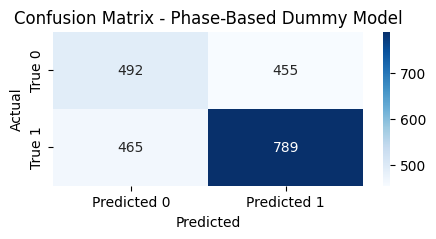

In [ ]:
class PhaseBasedDummyClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.phase_predictions = {}

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)

        # Assuming phase columns are 1 to 7
        phase_columns = X[:, 1:8]

        # For each phase, find the most frequent class
        for i in range(7):
            phase_mask = phase_columns[:, i] == 1
            if np.any(phase_mask):
                phase_y = y[phase_mask]
                most_frequent = np.argmax(np.bincount(phase_y))
                self.phase_predictions[i] = most_frequent
            else:
                self.phase_predictions[i] = 0  # Default to 0 if no samples for this phase

        self.is_fitted_ = True
        return self

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self, ['is_fitted_'])

        # Input validation
        X = check_array(X)

        phase_columns = X[:, 1:8]
        predictions = np.zeros(X.shape[0], dtype=int)

        for i in range(7):
            phase_mask = phase_columns[:, i] == 1
            predictions[phase_mask] = self.phase_predictions[i]

        return predictions

# Use the new classifier
dummy_phase_based = PhaseBasedDummyClassifier()
dummy_phase_based.fit(X_train, y_train)  # Use training data to fit
phase_based_predictions = dummy_phase_based.predict(X_val)

# Calculate metrics
accuracy = accuracy_score(y_val, phase_based_predictions)
f1 = f1_score(y_val, phase_based_predictions)

# Print metrics
print(f"Accuracy: {accuracy:.2f}")

print(f"F1 score: {f1:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, phase_based_predictions)
plt.figure(figsize=(5, 2))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Phase-Based Dummy Model')
plt.show()

For a dummy model, predicting the outcome only based on the clinical phase of the trials works remarkably well, with an F1 score of 0.63.

Let's take a look at how it performs for each phase.


Early phase 1:
Accuracy: 0.6250


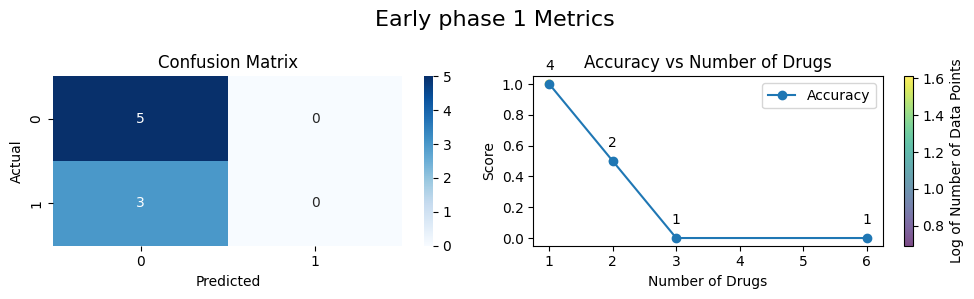


Phase 1:
Accuracy: 0.6061


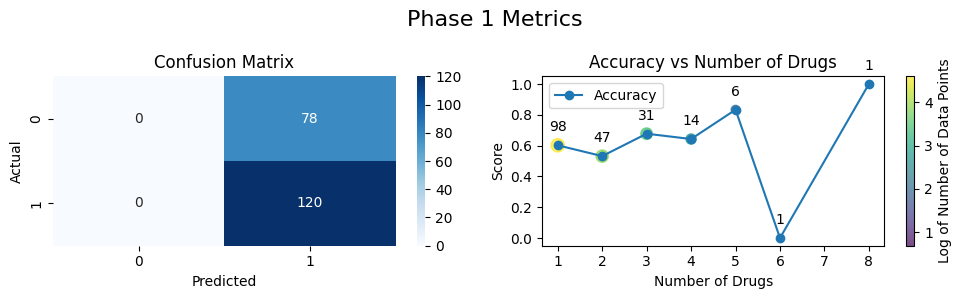


Phase 1/phase 2:
Accuracy: 0.5556


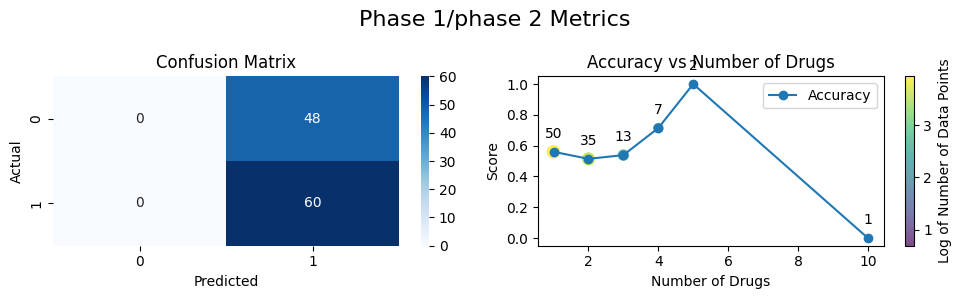


Phase 2:
Accuracy: 0.5000


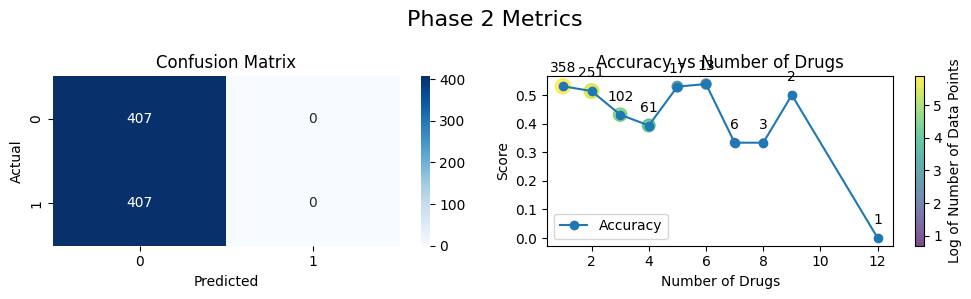


Phase 2/phase 3:
Accuracy: 0.5600


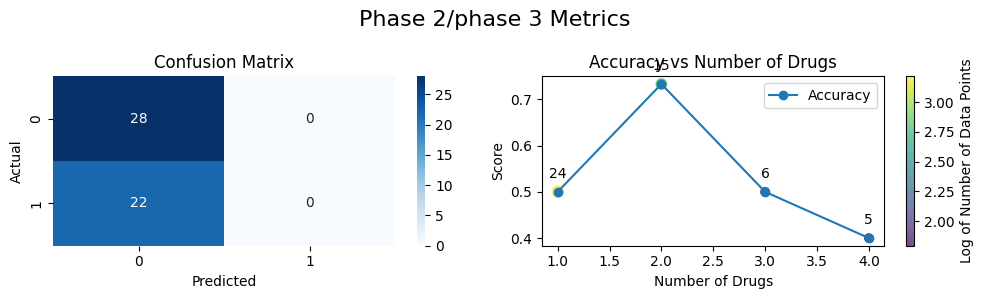


Phase 3:
Accuracy: 0.6857


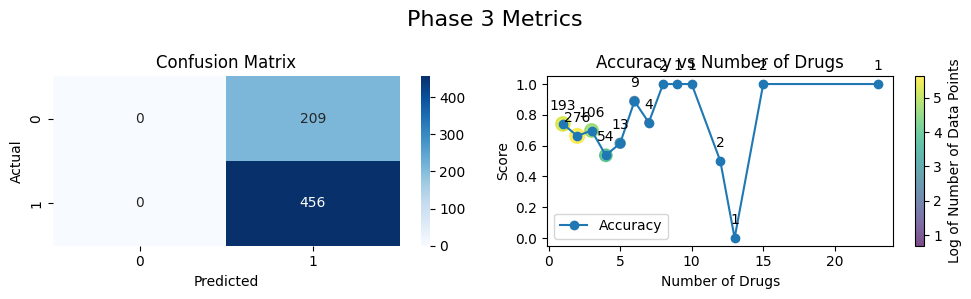


Phase 4:
Accuracy: 0.5604


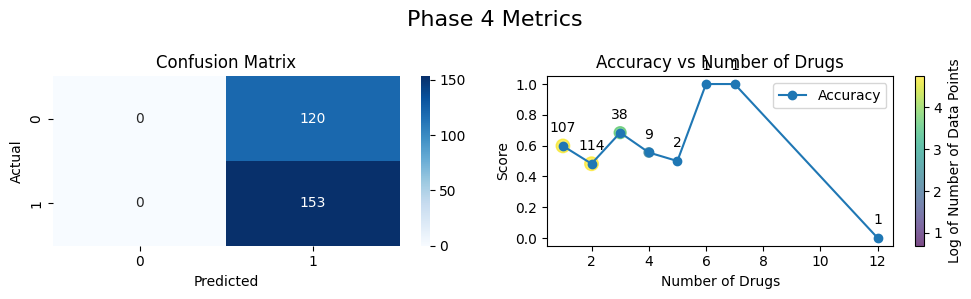

In [ ]:
# Define the phase labels
phase_labels = ['Early phase 1', 'Phase 1', 'Phase 1/phase 2', 'Phase 2', 'Phase 2/phase 3', 'Phase 3', 'Phase 4']

def plot_phase_metrics(X_val, y_val, predictions):
    if isinstance(X_val, pd.DataFrame):
        phase_columns = X_val.iloc[:, 1:8]
        n_drugs = X_val.iloc[:, 0]
    else:
        phase_columns = X_val[:, 1:8]
        n_drugs = X_val[:, 0]

    for i in range(7):
        phase_mask = phase_columns.iloc[:, i] if isinstance(phase_columns, pd.DataFrame) else phase_columns[:, i]
        phase_mask = phase_mask == 1

        if np.any(phase_mask):
            # Calculate and print overall accuracy for the phase
            phase_accuracy = accuracy_score(y_val[phase_mask], predictions[phase_mask])
            print(f"\n{phase_labels[i]}:")
            print(f"Accuracy: {phase_accuracy:.4f}")

            # Create a new figure for each phase
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
            fig.suptitle(f'{phase_labels[i]} Metrics', fontsize=16)

            # Confusion Matrix
            cm = confusion_matrix(y_val[phase_mask], predictions[phase_mask])
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
            ax1.set_title('Confusion Matrix')
            ax1.set_ylabel('Actual')
            ax1.set_xlabel('Predicted')

            # Metrics vs n_drugs
            phase_n_drugs = n_drugs[phase_mask]
            unique_n_drugs, counts = np.unique(phase_n_drugs, return_counts=True)
            accuracies = []
            sizes = []

            for n in unique_n_drugs:
                n_mask = phase_n_drugs == n
                acc = accuracy_score(y_val[phase_mask][n_mask], predictions[phase_mask][n_mask])
                accuracies.append(acc)
                sizes.append(np.sum(n_mask))  # Number of data points for each unique n_drugs

            # Convert sizes to a logarithmic scale for better visualization
            sizes = np.log1p(sizes)  # log1p(x) is log(x + 1), which avoids log(0)

            # Line Plot with Sizes
            ax2.plot(unique_n_drugs, accuracies, 'o-', label='Accuracy')
            scatter = ax2.scatter(unique_n_drugs, accuracies, s=[size * 20 for size in sizes], alpha=0.7, c=sizes, cmap='viridis')  # Use colormap to visualize sizes
            ax2.set_xlabel('Number of Drugs')
            ax2.set_ylabel('Score')
            ax2.set_title('Accuracy vs Number of Drugs')
            ax2.legend()

            # Add color bar for sizes
            cbar = plt.colorbar(scatter, ax=ax2)
            cbar.set_label('Log of Number of Data Points')

            # Add annotations for number of points
            for n, acc, size in zip(unique_n_drugs, accuracies, sizes):
                ax2.annotate(f'{np.expm1(size):.0f}', (n, acc), textcoords="offset points", xytext=(0,10), ha='center')

            plt.tight_layout()
            plt.show()
        else:
            print(f"\n{phase_labels[i]}: No data for this phase")

# Assuming you have X_train, y_train, X_val, y_val, and PhaseBasedDummyClassifier available
dummy_phase_based = PhaseBasedDummyClassifier()
dummy_phase_based.fit(X_train, y_train)
phase_based_predictions = dummy_phase_based.predict(X_val)

plot_phase_metrics(X_val, y_val, phase_based_predictions)

### XGBoost Benchmark

In [ ]:
# Define the objective function
def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, log=True),
        'gpu_id': 0,
        'tree_method': 'gpu_hist'
    }

    # Train the model with the given hyperparameters
    xgb_classifier = xgb.XGBClassifier(**param, random_state=42)
    xgb_classifier.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    # Predict on the validation set
    y_pred_val = xgb_classifier.predict(X_val)

    # Calculate F1 score
    f1 = f1_score(y_val, y_pred_val, average='weighted')
    return f1

# Create a study object
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Train the final model with the best hyperparameters
best_params = study.best_params
xgb_classifier = xgb.XGBClassifier(**best_params, random_state=42)
xgb_classifier.fit(X_train, y_train)

# Predict on training, validation, and test sets
y_pred_train = xgb_classifier.predict(X_train)
y_pred_val = xgb_classifier.predict(X_val)
y_pred_test = xgb_classifier.predict(X_test)

# Define the function to print metrics
def print_metrics(y_true, y_pred, set_name):
    roc_auc = roc_auc_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"\n{set_name} Set Metrics:")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Calculate and print metrics for training set
print_metrics(y_train, y_pred_train, "Training")

# Calculate and print metrics for validation set
print_metrics(y_val, y_pred_val, "Validation")

# Calculate and print metrics for test set
print_metrics(y_test, y_pred_test, "Test")

[I 2024-07-13 11:54:51,096] A new study created in memory with name: no-name-cd471548-422f-47c7-b9c6-dc1002b1e2bd
[I 2024-07-13 11:56:27,675] Trial 0 finished with value: 0.6636913761065885 and parameters: {'learning_rate': 0.025923106603815013, 'max_depth': 8, 'n_estimators': 835, 'reg_alpha': 6.0569153034614395e-05, 'reg_lambda': 0.002277457262995433, 'min_child_weight': 1, 'gamma': 1.9213137245256725e-05, 'colsample_bytree': 0.620332931888968, 'subsample': 0.897471854698301}. Best is trial 0 with value: 0.6636913761065885.
[I 2024-07-13 11:56:56,745] Trial 1 finished with value: 0.6552459551630885 and parameters: {'learning_rate': 0.013232406421084609, 'max_depth': 6, 'n_estimators': 380, 'reg_alpha': 2.7640308948850065e-06, 'reg_lambda': 0.07732927080980777, 'min_child_weight': 10, 'gamma': 4.958242206176876e-07, 'colsample_bytree': 0.6132293411792095, 'subsample': 0.6119034871392708}. Best is trial 0 with value: 0.6636913761065885.
[I 2024-07-13 11:57:34,215] Trial 2 finished with

Best hyperparameters:  {'learning_rate': 0.14724972716014836, 'max_depth': 7, 'n_estimators': 807, 'reg_alpha': 0.15782408342000456, 'reg_lambda': 0.017237284034464766, 'min_child_weight': 3, 'gamma': 2.784177206419087e-06, 'colsample_bytree': 0.6026501054459228, 'subsample': 0.9659997077044885}

Training Set Metrics:
ROC AUC: 0.9999
Accuracy: 0.9998
F1 Score: 0.9998

Validation Set Metrics:
ROC AUC: 0.6565
Accuracy: 0.6720
F1 Score: 0.6676

Test Set Metrics:
ROC AUC: 0.6750
Accuracy: 0.6889
F1 Score: 0.6855


Phase: early phase 1 (87 test data points)
F1 Score: 0.4262
Accuracy: 0.5977
ROC AUC: 0.6112



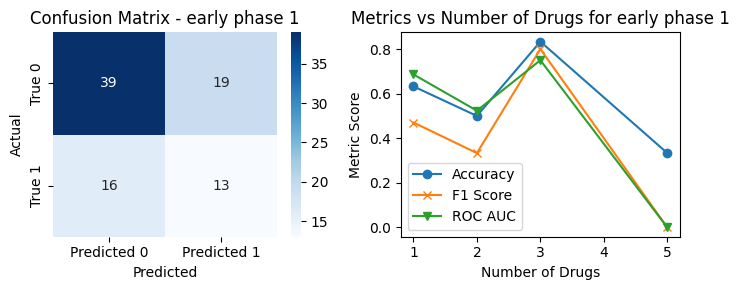

Phase: phase 1 (174 test data points)
F1 Score: 0.6667
Accuracy: 0.6207
ROC AUC: 0.6852



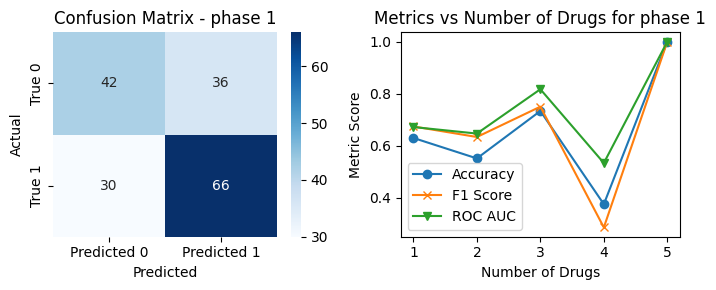

Phase: phase 1/phase 2 (85 test data points)
F1 Score: 0.7292
Accuracy: 0.6941
ROC AUC: 0.7434



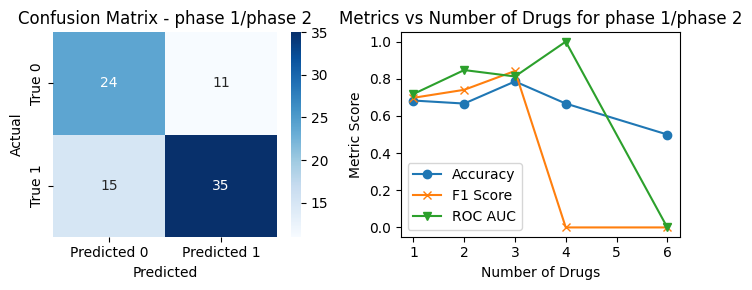

Phase: phase 2 (826 test data points)
F1 Score: 0.6468
Accuracy: 0.6550
ROC AUC: 0.7183



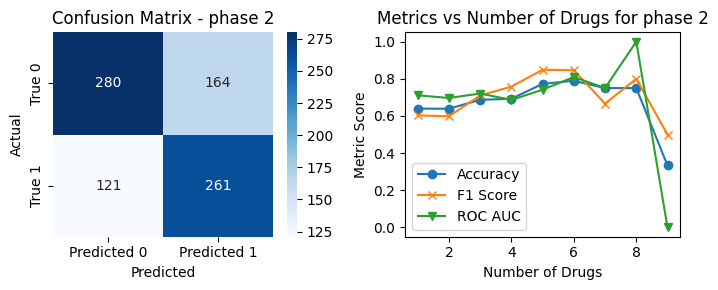

Phase: phase 2/phase 3 (32 test data points)
F1 Score: 0.6842
Accuracy: 0.6250
ROC AUC: 0.6706



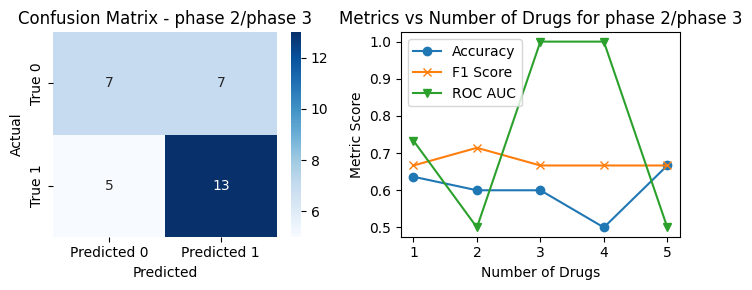

Phase: phase 3 (716 test data points)
F1 Score: 0.8466
Accuracy: 0.7737
ROC AUC: 0.8118



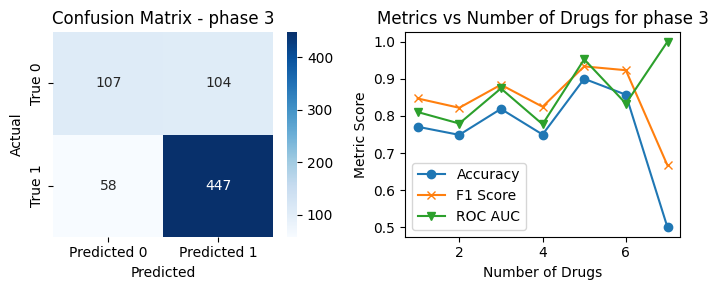

Phase: phase 4 (282 test data points)
F1 Score: 0.7346
Accuracy: 0.6489
ROC AUC: 0.6864



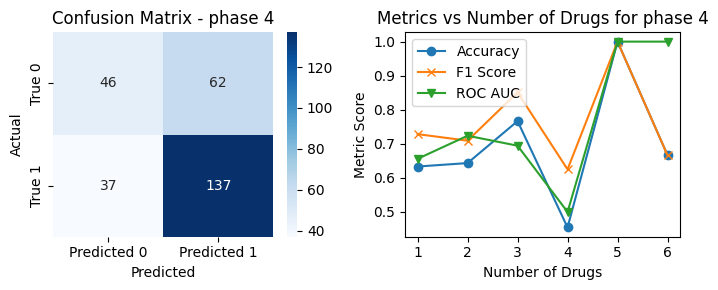

In [ ]:
# Make predictions with XGBoost model
xgb_predictions = xgb_classifier.predict(X_test)
xgb_prob_predictions = xgb_classifier.predict_proba(X_test)[:, 1]

# For metrics calculation, use ground truth labels
test_true = y_test

# Check if X_test is a DataFrame or numpy array
if isinstance(X_test, np.ndarray):
    # Extract n_drugs and phase information from numpy array
    test_n_drugs = X_test[:, 0]  # First column
    test_phases = X_test[:, 1:8]  # Columns for phases
elif isinstance(X_test, pd.DataFrame):
    # Extract n_drugs and phase information from DataFrame
    test_n_drugs = X_test.iloc[:, 0].values  # First column
    test_phases = X_test.iloc[:, 1:8].values  # Columns for phases
else:
    raise TypeError("X_test must be a numpy array or pandas DataFrame.")

# Decode one-hot encoded phases
decoded_phases = np.argmax(test_phases, axis=1)

# Dictionary to hold metrics for each phase
phase_metrics = {phase: {'num_samples': 0} for phase in phase_labels}

for i, phase in enumerate(phase_labels):
    phase_indices = decoded_phases == i
    phase_true = test_true[phase_indices]
    phase_pred = xgb_predictions[phase_indices]
    phase_prob = xgb_prob_predictions[phase_indices]
    phase_n_drugs = test_n_drugs[phase_indices]

    # Count number of test samples for this phase
    num_samples = len(phase_true)
    phase_metrics[phase]['num_samples'] = num_samples

    # Calculate metrics
    phase_f1 = f1_score(phase_true, phase_pred)
    phase_accuracy = accuracy_score(phase_true, phase_pred)
    try:
        phase_roc_auc = roc_auc_score(phase_true, phase_prob)
    except ValueError:
        phase_roc_auc = None

    # Store metrics
    phase_metrics[phase]['F1'] = phase_f1
    phase_metrics[phase]['Accuracy'] = phase_accuracy
    phase_metrics[phase]['ROC AUC'] = phase_roc_auc

    # Print metrics
    print(f'Phase: {phase} ({num_samples} test data points)')
    print(f'F1 Score: {phase_f1:.4f}')
    print(f'Accuracy: {phase_accuracy:.4f}')
    if phase_roc_auc is not None:
        print(f'ROC AUC: {phase_roc_auc:.4f}\n')
    else:
        print(f'ROC AUC: Not defined (only one class present)\n')

    # Compute confusion matrix
    conf_matrix = confusion_matrix(phase_true, phase_pred)

    # Error analysis for different n_drugs
    n_drugs_values = []
    n_drugs_accuracies = []
    n_drugs_f1s = []
    n_drugs_roc_aucs = []

    for n_drugs in np.unique(phase_n_drugs):
        n_drugs_indices = phase_n_drugs == n_drugs
        n_drugs_true = phase_true[n_drugs_indices]
        n_drugs_pred = phase_pred[n_drugs_indices]
        n_drugs_prob = phase_prob[n_drugs_indices]

        # Check if both classes are present in n_drugs_true
        if len(np.unique(n_drugs_true)) < 2:
            continue

        # Calculate metrics for current n_drugs
        n_drugs_accuracy = accuracy_score(n_drugs_true, n_drugs_pred)
        n_drugs_f1 = f1_score(n_drugs_true, n_drugs_pred)
        try:
            n_drugs_roc_auc = roc_auc_score(n_drugs_true, n_drugs_prob)
        except ValueError:
            n_drugs_roc_auc = None

        n_drugs_values.append(n_drugs)
        n_drugs_accuracies.append(n_drugs_accuracy)
        n_drugs_f1s.append(n_drugs_f1)
        if n_drugs_roc_auc is not None:
            n_drugs_roc_aucs.append(n_drugs_roc_auc)

    # Plot confusion matrix and metrics vs n_drugs
    fig, axes = plt.subplots(1, 2, figsize=(7, 3))

    # Confusion matrix subplot
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'], ax=axes[0])
    axes[0].set_ylabel('Actual')
    axes[0].set_xlabel('Predicted')
    axes[0].set_title(f'Confusion Matrix - {phase}')

    # Metrics vs n_drugs subplot
    axes[1].plot(n_drugs_values, n_drugs_accuracies, marker='o', label='Accuracy')
    axes[1].plot(n_drugs_values, n_drugs_f1s, marker='x', label='F1 Score')
    if len(n_drugs_roc_aucs) > 0:
        axes[1].plot(n_drugs_values, n_drugs_roc_aucs, marker='v', label='ROC AUC')
    axes[1].set_xlabel('Number of Drugs')
    axes[1].set_ylabel('Metric Score')
    axes[1].set_title(f'Metrics vs Number of Drugs for {phase}')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

### Multi-input Neural Network

In [ ]:
def ensure_numeric(df):
    return df.apply(pd.to_numeric, errors='coerce').fillna(0)

X_train = ensure_numeric(X_train)
X_val = ensure_numeric(X_val)
X_test = ensure_numeric(X_test)

y_train = pd.to_numeric(y_train, errors='coerce').fillna(0)
y_val = pd.to_numeric(y_val, errors='coerce').fillna(0)
y_test = pd.to_numeric(y_test, errors='coerce').fillna(0)


# Separating the inputs
drugs = [col for col in X_train.columns if col.startswith('ChemBERTa_')]
train_drugs, val_drugs, test_drugs = X_train[drugs].to_numpy().astype(np.float32), X_val[drugs].to_numpy().astype(np.float32), X_test[drugs].to_numpy().astype(np.float32)  # drug embeddings

diseases = [col for col in X_train.columns if col.startswith('Disease_')]
train_diseases, val_diseases, test_diseases = X_train[diseases].to_numpy().astype(np.float32), X_val[diseases].to_numpy().astype(np.float32), X_test[diseases].to_numpy().astype(np.float32)  # disease embeddings

inclusions = [col for col in X_train.columns if col.startswith('Inclusion_')]
train_inclusion, val_inclusion, test_inclusion = X_train[inclusions].to_numpy().astype(np.float32), X_val[inclusions].to_numpy().astype(np.float32), X_test[inclusions].to_numpy().astype(np.float32)  # inclusion/exclusion embeddings

exclusions = [col for col in X_train.columns if col.startswith('Exclusion_')]
train_exclusion, val_exclusion, test_exclusion = X_train[exclusions].to_numpy().astype(np.float32), X_val[exclusions].to_numpy().astype(np.float32), X_test[exclusions].to_numpy().astype(np.float32)  # inclusion/exclusion embeddings

summaries = [col for col in X_train.columns if col.startswith('Brief_summary_')]
train_summary, val_summary, test_summary = X_train[summaries].to_numpy().astype(np.float32), X_val[summaries].to_numpy().astype(np.float32), X_test[summaries].to_numpy().astype(np.float32)  # brief summary embeddings

numerical = [col for col in X_train.columns if col not in drugs + diseases + inclusions + exclusions + summaries]
train_numerical, val_numerical, test_numerical = X_train[numerical].to_numpy().astype(np.float32), X_val[numerical].to_numpy().astype(np.float32), X_test[numerical].to_numpy().astype(np.float32)  # numerical features

train_labels, val_labels, test_labels = pd.DataFrame(y_train).to_numpy().astype(np.float32), pd.DataFrame(y_val).to_numpy().astype(np.float32), pd.DataFrame(y_test).to_numpy().astype(np.float32)  # labels

# Create datasets and dataloaders
class ClinicalTrialDataset(Dataset):
    def __init__(self, drugs, diseases, inclusion, exclusion, summary, numerical, labels):
        self.drugs = drugs
        self.diseases = diseases
        self.inclusion = inclusion
        self.exclusion = exclusion
        self.summary = summary
        self.numerical = numerical
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.drugs[idx], dtype=torch.float32),
            torch.tensor(self.diseases[idx], dtype=torch.float32),
            torch.tensor(self.inclusion[idx], dtype=torch.float32),
            torch.tensor(self.exclusion[idx], dtype=torch.float32),
            torch.tensor(self.summary[idx], dtype=torch.float32),
            torch.tensor(self.numerical[idx], dtype=torch.float32),
            torch.tensor(self.labels[idx], dtype=torch.float32)
        )

train_dataset = ClinicalTrialDataset(train_drugs, train_diseases, train_inclusion, train_exclusion, train_summary, train_numerical, train_labels)
val_dataset = ClinicalTrialDataset(val_drugs, val_diseases, val_inclusion, val_exclusion, val_summary, val_numerical, val_labels)
test_dataset = ClinicalTrialDataset(test_drugs, test_diseases, test_inclusion, test_exclusion, test_summary, test_numerical, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
class MultiInputNN(nn.Module):
    def __init__(self, drug_dim=384, disease_dim=768, text_dim=768, num_features=8):
        super(MultiInputNN, self).__init__()

        # Separate processing layers for each input type
        self.drug_layer = nn.Sequential(
            nn.Linear(drug_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.3)
        )

        self.disease_layer = nn.Sequential(
            nn.Linear(disease_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.3)
        )

        self.inclusion_layer = nn.Sequential(
            nn.Linear(text_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
        )

        self.exclusion_layer = nn.Sequential(
            nn.Linear(text_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
        )

        self.brief_summary_layer = nn.Sequential(
            nn.Linear(text_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.3)
        )

        # Joint processing layers
        combined_dim = 64*5 + num_features  # 5 processed inputs + numerical features
        self.joint_layers = nn.Sequential(
            nn.Linear(combined_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, drug, disease, inclusion, exclusion, brief_summary, numerical):
        drug_processed = self.drug_layer(drug)
        disease_processed = self.disease_layer(disease)
        inclusion_processed = self.inclusion_layer(inclusion)
        exclusion_processed = self.exclusion_layer(exclusion)
        brief_summary_processed = self.brief_summary_layer(brief_summary)

        combined = torch.cat([drug_processed, disease_processed,
                              inclusion_processed, exclusion_processed,
                              brief_summary_processed,
                              numerical], dim=1)

        output = self.joint_layers(combined)
        return output

In [ ]:
# Initialize model, loss function, and optimizer
model = MultiInputNN(drug_dim=384, disease_dim=768, text_dim=768, num_features=8)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0075, weight_decay=1e-5)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5)

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_true = []
    train_pred = []

    for batch in train_loader:
        drug, disease, inclusion, exclusion, brief_summary, numerical, labels = batch

        # Forward pass
        outputs = model(drug, disease, inclusion, exclusion, brief_summary, numerical)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Accumulate true and predicted labels for metrics
        train_true.extend(labels.numpy())
        train_pred.extend(outputs.detach().numpy().round())

    # Compute training metrics
    train_f1 = f1_score(train_true, train_pred)
    train_accuracy = accuracy_score(train_true, train_pred)
    train_precision = precision_score(train_true, train_pred)
    train_recall = recall_score(train_true, train_pred)
    train_roc_auc = roc_auc_score(train_true, train_pred)

    # Validation
    model.eval()
    val_loss = 0.0
    val_true = []
    val_pred = []

    with torch.no_grad():
        for batch in val_loader:
            drug, disease, inclusion, exclusion, brief_summary, numerical, labels = batch
            outputs = model(drug, disease, inclusion, exclusion, brief_summary, numerical)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Accumulate true and predicted labels for metrics
            val_true.extend(labels.numpy())
            val_pred.extend(outputs.numpy().round())

    # Compute validation metrics
    val_f1 = f1_score(val_true, val_pred)
    val_accuracy = accuracy_score(val_true, val_pred)
    val_precision = precision_score(val_true, val_pred)
    val_recall = recall_score(val_true, val_pred)
    val_roc_auc = roc_auc_score(val_true, val_pred)

    # Learning rate scheduling
    #scheduler.step(val_loss)

    # Print metrics for the current epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}, '
          f'Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, '
          f'Train Precision: {train_precision:.4f}, Val Precision: {val_precision:.4f}, '
          f'Train Recall: {train_recall:.4f}, Val Recall: {val_recall:.4f}, '
          f'Train ROC AUC: {train_roc_auc:.4f}, Val ROC AUC: {val_roc_auc:.4f}')

Epoch [1/3], Train Loss: 0.6202, Val Loss: 0.6139, Train F1: 0.7017, Val F1: 0.6934, Train Accuracy: 0.6541, Val Accuracy: 0.6520, Train Precision: 0.6896, Val Precision: 0.6961, Train Recall: 0.7142, Val Recall: 0.6906, Train ROC AUC: 0.6444, Val ROC AUC: 0.6457
Epoch [2/3], Train Loss: 0.5920, Val Loss: 0.6105, Train F1: 0.7290, Val F1: 0.7032, Train Accuracy: 0.6875, Val Accuracy: 0.6624, Train Precision: 0.7204, Val Precision: 0.7046, Train Recall: 0.7377, Val Recall: 0.7018, Train ROC AUC: 0.6794, Val ROC AUC: 0.6561
Epoch [3/3], Train Loss: 0.5717, Val Loss: 0.6174, Train F1: 0.7439, Val F1: 0.7143, Train Accuracy: 0.7074, Val Accuracy: 0.6602, Train Precision: 0.7417, Val Precision: 0.6855, Train Recall: 0.7460, Val Recall: 0.7456, Train ROC AUC: 0.7011, Val ROC AUC: 0.6463


In [ ]:
## Save model
save_path = '/content/drive/MyDrive/Colab Notebooks/Clinical Trials Outcomes/models/multi_modal_NN.pth'  # Change this to your mounted drive path

# Saving model to drive
torch.save(model, save_path)

Phase: early phase 1 (87 test data points)
F1 Score: 0.5172
Accuracy: 0.6782
Precision: 0.5172
Recall: 0.5172
ROC AUC: 0.6379



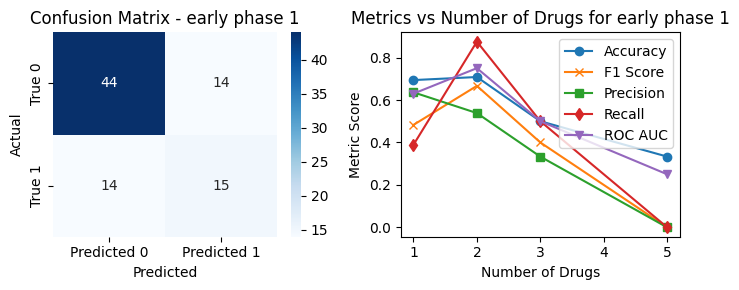

Phase: phase 1 (174 test data points)
F1 Score: 0.6984
Accuracy: 0.6724
Precision: 0.7097
Recall: 0.6875
ROC AUC: 0.6707



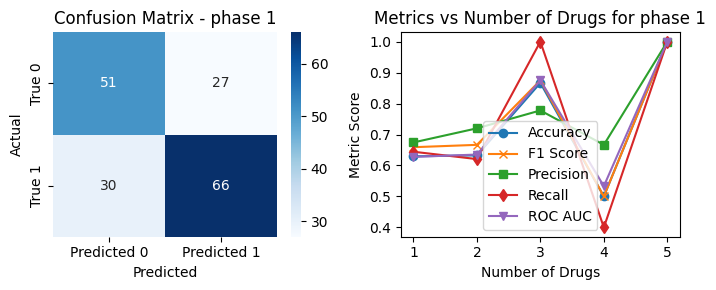

Phase: phase 1/phase 2 (85 test data points)
F1 Score: 0.7083
Accuracy: 0.6706
Precision: 0.7391
Recall: 0.6800
ROC AUC: 0.6686



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


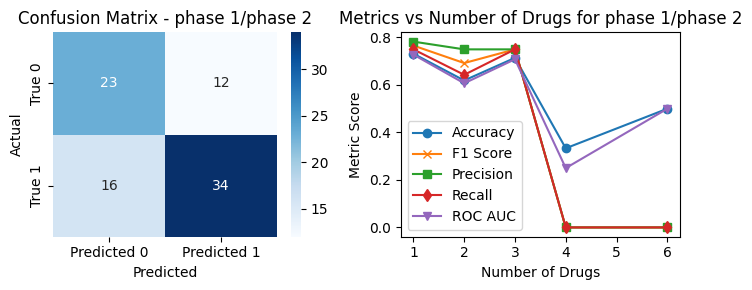

Phase: phase 2 (826 test data points)
F1 Score: 0.6397
Accuracy: 0.6550
Precision: 0.6186
Recall: 0.6623
ROC AUC: 0.6555



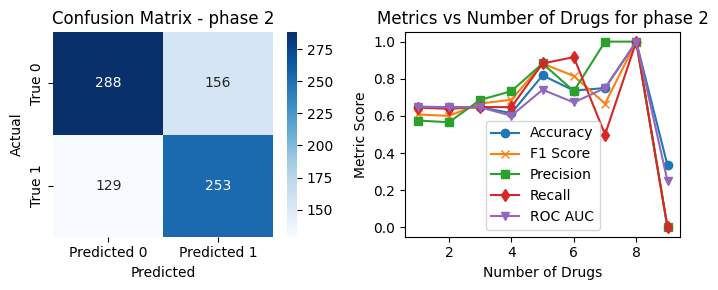

Phase: phase 2/phase 3 (32 test data points)
F1 Score: 0.6500
Accuracy: 0.5625
Precision: 0.5909
Recall: 0.7222
ROC AUC: 0.5397



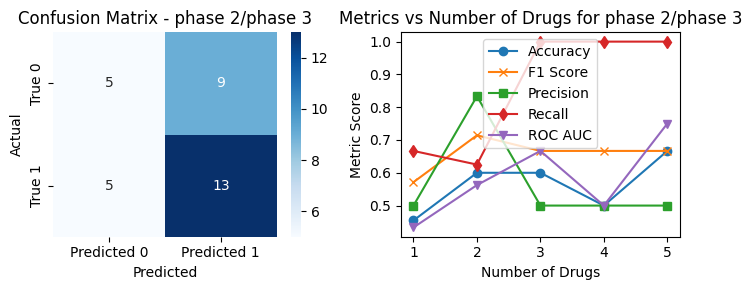

Phase: phase 3 (716 test data points)
F1 Score: 0.8513
Accuracy: 0.7765
Precision: 0.8021
Recall: 0.9069
ROC AUC: 0.6857



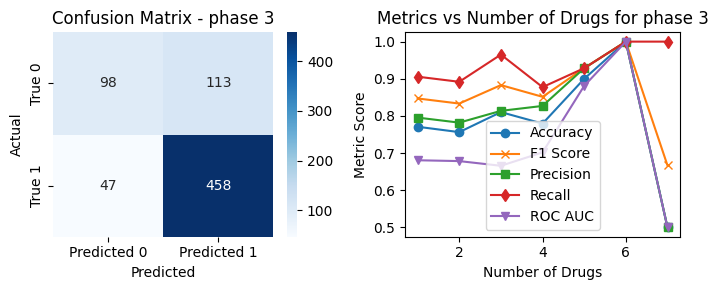

Phase: phase 4 (282 test data points)
F1 Score: 0.7154
Accuracy: 0.5993
Precision: 0.6368
Recall: 0.8161
ROC AUC: 0.5330



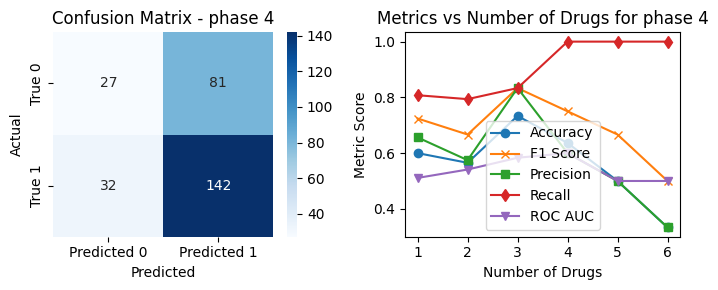

In [ ]:
# Phase labels corresponding to one-hot encoded columns
phase_labels = ['early phase 1', 'phase 1', 'phase 1/phase 2', 'phase 2', 'phase 2/phase 3', 'phase 3', 'phase 4']

# Model evaluation on the test set
model.eval()
test_true = []
test_pred = []
test_phases = []
test_n_drugs = []

with torch.no_grad():
    for batch in test_loader:
        drug, disease, inclusion, exclusion, brief_summary, numerical, labels = batch
        outputs = model(drug, disease, inclusion, exclusion, brief_summary, numerical)

        test_true.extend(labels.numpy())
        test_pred.extend(outputs.numpy().round())

        # Extract phase information from numerical features (excluding the first column)
        test_phases.extend(numerical[:, 1:].numpy())
        # Extract n_drugs (first column)
        test_n_drugs.extend(numerical[:, 0].numpy())

test_true = np.array(test_true)
test_pred = np.array(test_pred)
test_phases = np.array(test_phases)
test_n_drugs = np.array(test_n_drugs)

# Decode one-hot encoded phases
decoded_phases = np.argmax(test_phases, axis=1)

# Dictionary to hold metrics for each phase
phase_metrics = {phase: {'num_samples': 0} for phase in phase_labels}

for i, phase in enumerate(phase_labels):
    phase_indices = decoded_phases == i
    phase_true = test_true[phase_indices]
    phase_pred = test_pred[phase_indices]
    phase_n_drugs = test_n_drugs[phase_indices]

    # Count number of test samples for this phase
    num_samples = len(phase_true)
    phase_metrics[phase]['num_samples'] = num_samples

    # Calculate metrics
    phase_f1 = f1_score(phase_true, phase_pred)
    phase_accuracy = accuracy_score(phase_true, phase_pred)
    phase_precision = precision_score(phase_true, phase_pred)
    phase_recall = recall_score(phase_true, phase_pred)
    try:
        phase_roc_auc = roc_auc_score(phase_true, phase_pred)
    except ValueError:
        phase_roc_auc = None

    # Store metrics
    phase_metrics[phase]['F1'] = phase_f1
    phase_metrics[phase]['Accuracy'] = phase_accuracy
    phase_metrics[phase]['Precision'] = phase_precision
    phase_metrics[phase]['Recall'] = phase_recall
    phase_metrics[phase]['ROC AUC'] = phase_roc_auc

    # Print metrics
    print(f'Phase: {phase} ({num_samples} test data points)')
    print(f'F1 Score: {phase_f1:.4f}')
    print(f'Accuracy: {phase_accuracy:.4f}')
    print(f'Precision: {phase_precision:.4f}')
    print(f'Recall: {phase_recall:.4f}')
    if phase_roc_auc is not None:
        print(f'ROC AUC: {phase_roc_auc:.4f}\n')
    else:
        print(f'ROC AUC: Not defined (only one class present)\n')

    # Compute confusion matrix
    conf_matrix = confusion_matrix(phase_true, phase_pred)

    # Error analysis for different n_drugs
    n_drugs_values = []
    n_drugs_accuracies = []
    n_drugs_f1s = []
    n_drugs_precisions = []
    n_drugs_recalls = []
    n_drugs_roc_aucs = []

    for n_drugs in np.unique(phase_n_drugs):
        n_drugs_indices = phase_n_drugs == n_drugs
        n_drugs_true = phase_true[n_drugs_indices]
        n_drugs_pred = phase_pred[n_drugs_indices]

        # Check if both classes are present in n_drugs_true
        if len(np.unique(n_drugs_true)) < 2:
            continue

        # Calculate metrics for current n_drugs
        n_drugs_accuracy = accuracy_score(n_drugs_true, n_drugs_pred)
        n_drugs_f1 = f1_score(n_drugs_true, n_drugs_pred)
        n_drugs_precision = precision_score(n_drugs_true, n_drugs_pred)
        n_drugs_recall = recall_score(n_drugs_true, n_drugs_pred)
        try:
            n_drugs_roc_auc = roc_auc_score(n_drugs_true, n_drugs_pred)
        except ValueError:
            n_drugs_roc_auc = None

        n_drugs_values.append(n_drugs)
        n_drugs_accuracies.append(n_drugs_accuracy)
        n_drugs_f1s.append(n_drugs_f1)
        n_drugs_precisions.append(n_drugs_precision)
        n_drugs_recalls.append(n_drugs_recall)
        if n_drugs_roc_auc is not None:
            n_drugs_roc_aucs.append(n_drugs_roc_auc)

    # Plot confusion matrix and metrics vs n_drugs
    fig, axes = plt.subplots(1, 2, figsize=(7, 3))

    # Confusion matrix subplot
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'], ax=axes[0])
    axes[0].set_ylabel('Actual')
    axes[0].set_xlabel('Predicted')
    axes[0].set_title(f'Confusion Matrix - {phase}')

    # Metrics vs n_drugs subplot
    axes[1].plot(n_drugs_values, n_drugs_accuracies, marker='o', label='Accuracy')
    axes[1].plot(n_drugs_values, n_drugs_f1s, marker='x', label='F1 Score')
    axes[1].plot(n_drugs_values, n_drugs_precisions, marker='s', label='Precision')
    axes[1].plot(n_drugs_values, n_drugs_recalls, marker='d', label='Recall')
    if len(n_drugs_roc_aucs) > 0:
        axes[1].plot(n_drugs_values, n_drugs_roc_aucs, marker='v', label='ROC AUC')
    axes[1].set_xlabel('Number of Drugs')
    axes[1].set_ylabel('Metric Score')
    axes[1].set_title(f'Metrics vs Number of Drugs for {phase}')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

### Comparison of model performance

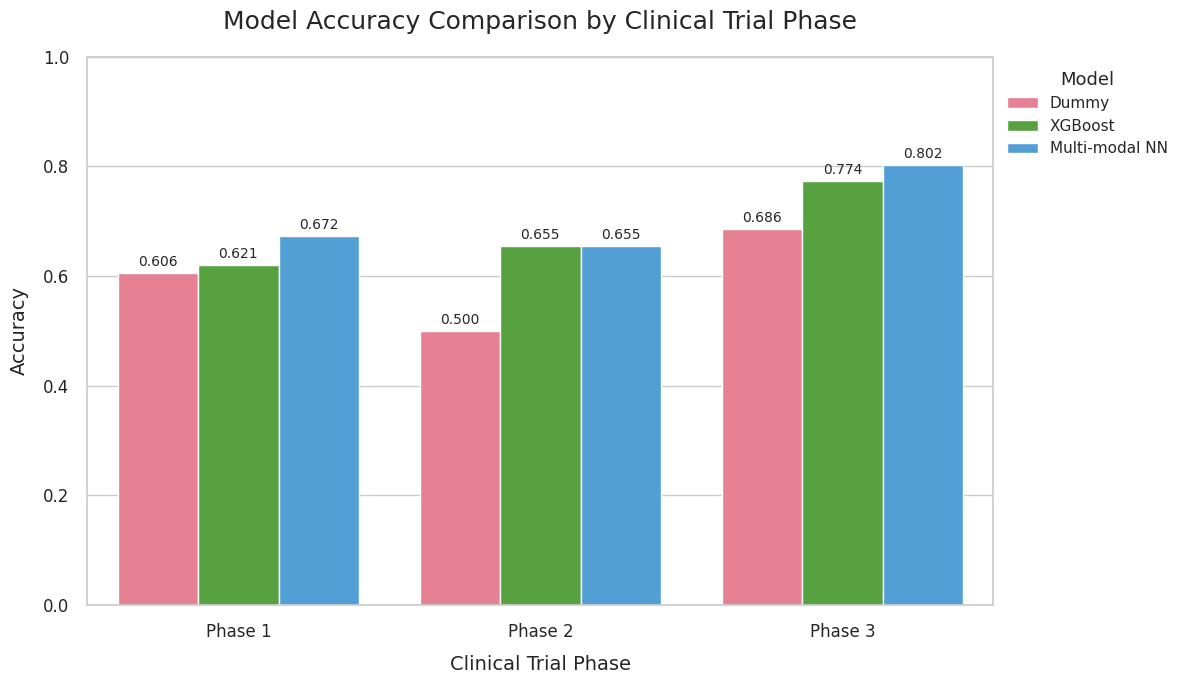

In [ ]:
# Data Preparation
data = {
    'Phase': ['Phase 1', 'Phase 2', 'Phase 3'],
    'Dummy': [0.6061, 0.5, 0.6857],
    'XGBoost': [0.6207, 0.6550, 0.7737],
    'Multi-modal NN': [0.6724, 0.6550, 0.8021]
}

# Convert data to DataFrame
df = pd.DataFrame(data)
df_melted = df.melt(id_vars='Phase', var_name='Model', value_name='Accuracy')

# Set the Seaborn style
sns.set_theme(style="whitegrid")

# Plotting
fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(data=df_melted, x='Phase', y='Accuracy', hue='Model', palette="husl", ax=ax)

# Customize the plot
ax.set_title('Model Accuracy Comparison by Clinical Trial Phase', fontsize=18, pad=20)
ax.set_xlabel('Clinical Trial Phase', fontsize=14, labelpad=10)
ax.set_ylabel('Accuracy', fontsize=14, labelpad=10)
ax.set_ylim(0, 1)  # Keep the accuracy scale from 0 to 1
ax.tick_params(axis='both', which='major', labelsize=12)

# Add value labels on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=10)

# Customize the legend
ax.legend(title='Model', title_fontsize='13', fontsize='11', loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout and show plot
plt.tight_layout()
plt.show()

The Multi-modal Neural Network architecture demonstrated superior performance compared to both the Dummy model (which predicts solely based on the trial phase) and the XGBoost model. This performance hierarchy highlights the effectiveness of the Multi-modal NN in capturing complex relationships within clinical trial data.

A notable observation is the varying difficulty in predicting outcomes across different clinical trial phases. Phase 1 and Phase 2 trials proved considerably more challenging to predict than Phase 3 trials. This discrepancy likely reflects the inherent uncertainty in earlier stages of drug development and testing.

The Dummy model's significantly lower performance underscores the predictive power of both the XGBoost and Multi-modal NN models. These advanced models successfully extracted meaningful patterns from diverse data sources, including information about the drugs used, diseases targeted, and trial protocols. Their ability to outperform the phase-based Dummy model indicates that they captured nuanced relationships between these factors and the probability of trial success.

### Comparison to HINT benchmark

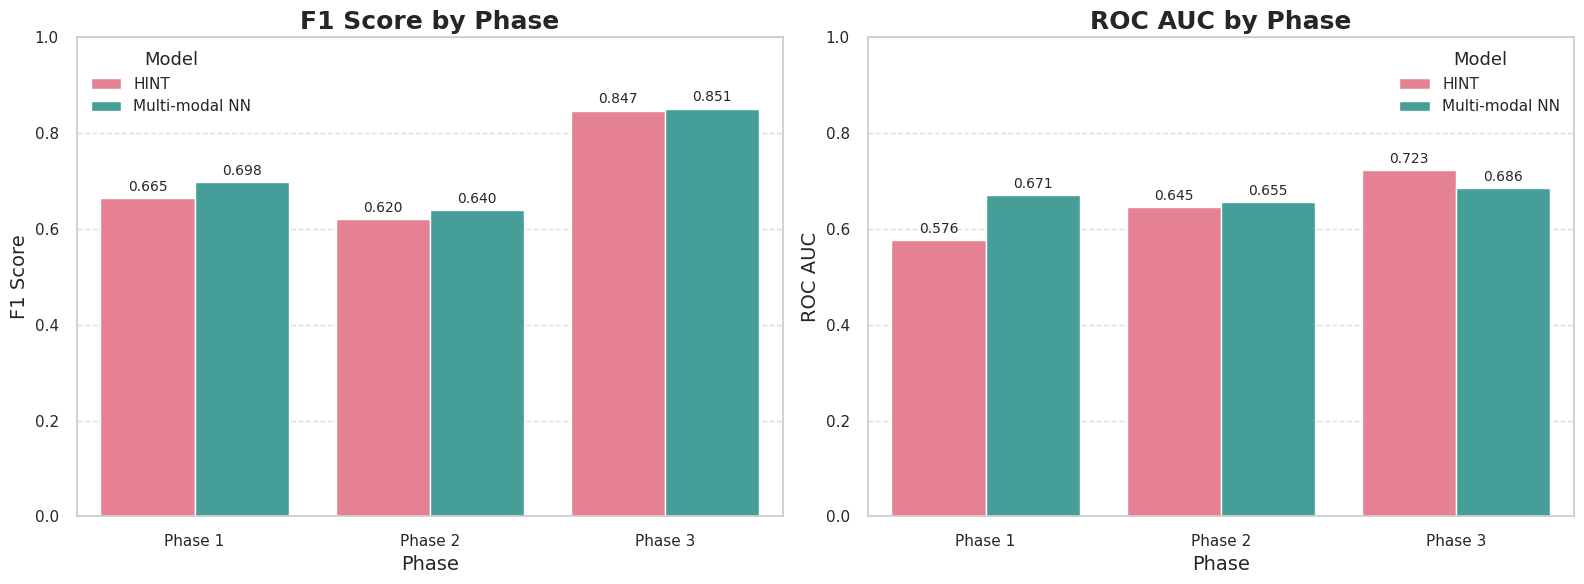

In [ ]:
data_f1 = {
    'Phase': ['Phase 1', 'Phase 2', 'Phase 3'],
    'HINT': [0.665, 0.620, 0.847],
    'Multi-modal NN': [0.6984, 0.6397, 0.8513]
}

data_roc_auc = {
    'Phase': ['Phase 1', 'Phase 2', 'Phase 3'],
    'HINT': [0.576, 0.645, 0.723],
    'Multi-modal NN': [0.6707, 0.6555, 0.6857]
}

# Convert data to DataFrame
df_f1 = pd.DataFrame(data_f1)
df_roc_auc = pd.DataFrame(data_roc_auc)

# Melt the DataFrames for plotting
df_f1_melted = df_f1.melt(id_vars='Phase', var_name='Model', value_name='F1 Score')
df_roc_auc_melted = df_roc_auc.melt(id_vars='Phase', var_name='Model', value_name='ROC-AUC')

# Set the color palette
palette = sns.color_palette("husl", 2)  # A vibrant color palette

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot F1 Score
sns.barplot(data=df_f1_melted, x='Phase', y='F1 Score', hue='Model', palette=palette, ax=axs[0])
axs[0].set_title('F1 Score by Phase', fontsize=18, fontweight='bold')
axs[0].set_xlabel('Phase', fontsize=14)
axs[0].set_ylabel('F1 Score', fontsize=14)
axs[0].set_ylim(0, 1)  # To keep the F1 Score scale from 0 to 1
axs[0].legend(title='Model', title_fontsize='13', fontsize='11')
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels for F1 Score
containers = axs[0].containers
for container in containers:
    axs[0].bar_label(container, fmt='%.3f', padding=3, fontsize=10)  # Add data labels

# Plot ROC AUC
sns.barplot(data=df_roc_auc_melted, x='Phase', y='ROC-AUC', hue='Model', palette=palette, ax=axs[1])
axs[1].set_title('ROC-AUC by Phase', fontsize=18, fontweight='bold')
axs[1].set_xlabel('Phase', fontsize=14)
axs[1].set_ylabel('ROC-AUC', fontsize=14)
axs[1].set_ylim(0, 1)  # To keep the ROC AUC scale from 0 to 1
axs[1].legend(title='Model', title_fontsize='13', fontsize='11')
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels for ROC AUC
containers = axs[1].containers
for container in containers:
    axs[1].bar_label(container, fmt='%.3f', padding=3, fontsize=10)  # Add data labels

# Adjust layout
plt.tight_layout()
plt.show()

## Conclusion

The multi-modal neural network architecture achieved accuracies of 67%, 65% and 80% for Phases I, II and III, respectively, performing better than the more simple dummy model and XGB model.  

It performed slightly better than the more elaborate HINT model.

This would suggest that the intuition highlighted in the HINT paper --that improvements on the previous state-of-the-art models are in no small part due to the incorporation of insightful, multi-modal data-- is mostly right.  

Some of the main differences in the data between this work and the HINT paper:

  - In this work the SMILES data was embedded using ChemBERTa, while the HINT model was trained on Morgan fingerprints.

  - Criteria was separated into inclusion and exclusion, and embedded with BioSimCSE instead of BioBERT.

  - A brief summary of the protocol was used as an additional input, complementing the protocol information contained in the inclusion/exclusion criteria. This was also encoded using BioSimCSE.

  - ADMET data was not directly used in this work

## Bibliography

<!-- Move to BibTex style bibliography later - need to figure out how to do it on Jupyter -->

[1] - Singh, N., Vayer, P., Tanwar, S., Poyet, J.-L., Tsaioun, K., & Villoutreix, B. O. (2023). Drug discovery and development: introduction to the general public and patient groups. In Frontiers in Drug Discovery (Vol. 3). Frontiers Media SA. https://doi.org/10.3389/fddsv.2023.1201419

[2] - Simoens, S., & Huys, I. (2021). R&D Costs of New Medicines: A Landscape Analysis. In Frontiers in Medicine (Vol. 8). Frontiers Media SA. https://doi.org/10.3389/fmed.2021.760762

[3] - Thomas D, Micklus A, LaFever S. Clinical development success rates and contributing factors 2011–2020. 2021.

[4] - Sun, D., Gao, W., Hu, H., & Zhou, S. (2022). Why 90% of clinical drug development fails and how to improve it? Acta Pharmaceutica Sinica B, 12(7), 3049–3062. https://doi.org/10.1016/j.apsb.2022.02.002

[5] - Fu, T., Huang, K., Xiao, C., Glass, L. M., & Sun, J. (2022). HINT: Hierarchical interaction network for clinical-trial-outcome predictions. In Patterns (Vol. 3, Issue 4, p. 100445). Elsevier BV. https://doi.org/10.1016/j.patter.2022.100445

[6] - Rohanian, O., Nouriborji, M., Kouchaki, S., & Clifton, D. A. (2022). On the Effectiveness of Compact Biomedical Transformers. arXiv (Cornell University). https://doi.org/10.48550/arxiv.2209.03182

[7] - Kanakarajan, K. R., Kundumani, B., Abraham, A., & Sankarasubbu, M. (2022). BioSimCSE: BioMedical Sentence Embeddings using Contrastive learning. ACL Anthology. https://doi.org/10.18653/v1/2022.louhi-1.10

[8] - Ahmad, W., Simon, E., Chithrananda, S., Grand, G., & Ramsundar, B. (2022). ChemBERTA-2: towards Chemical foundation models. arXiv (Cornell University). https://doi.org/10.48550/arxiv.2209.01712

[9] - Pang, J., Pine, A. W. R., & Sulemana, A. (2024). Using natural language processing (NLP)-inspired molecular embedding approach to predict Hansen solubility parameters. Digital Discovery, 3(1), 145–154. https://doi.org/10.1039/d3dd00119a